# SAE DataMining 
# CLANET Guilhem - LELEU Anne - VIVIEN Cédric 
# BUT 3 EMS 

## Importation des bibliothèques

In [2]:
import numpy as np
import pandas as pd  
from matplotlib import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve,r2_score, accuracy_score, accuracy_score, confusion_matrix, f1_score, recall_score,precision_score,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings("ignore")

## Toutes les fonctions utiles

In [37]:
def load_data(file_path):
    """charge un ficher csv

    Args:
        file_path (lien): le lien du ficher csv à importer

    Returns:
        data, int: retourne les données, le nombre de ligne et le combre de colonne
    """
    data = pd.read_csv(file_path)
    return data, data.shape[0], data.shape[1]

def lire_donnes(dataframe, lignes, colonnes):
    """permet de lire un fichier et d'afficher les informations importantes

    Args:
        dataframe (dataframe): dataframe contenant les données à lire
        lignes (int): le nombre de lignes
        colonnes (int): le nombre de lignes
    """
    df, lignes, colonnes = dataframe, lignes, colonnes
    print("Nombre de lignes : ", lignes)
    print("Nombre de colonnes : ", colonnes)
    print(df.head())

def check_valeur_unique(dataframe):
    """permet de donner les valeurs uniques pour les variables d'un dataframe

    :param dataframe: dataframe contenant les données
    :type dataframe: df
    """
    for var in dataframe.columns:
        print("Variable :", var, "Valeur :", dataframe[var].unique())

def replace_value_with_nan(dataframe, var, character):
    """remplace, pour une colonne d'un dataframe le character voulu par NaN
    
    :param dataframe: le dataframe contenant les données
    :type dataframe: data
    :param var: la colonne sur laquelle on veut appliquer la fonction
    :type var: str
    :param character: le character qui doit etre modifié
    :type character: srt
    :return: le dataframe avec la colonne qui a été modifié
    :rtype: data

    """
    dataframe[var]=dataframe[var].replace(character, np.nan)
    return dataframe

def conversion(dataframe, type_voulu, colonne):
    """
    cchange le type d'une colonne 
    
    :param dataframe: le dataframe contenant les données
    :type dataframe: data
    :param type_voulu: type de données 
    :type type_voulu: str,int, boolean ... 
    :param colonne: colonne à modifier 
    :type colonne: str,int, boolean ... 
    :return: le dataframe avec la colonne qui a été modifié par son type 
    :rtype: data
    """
    dataframe[colonne] = dataframe[colonne].astype(type_voulu)
    return dataframe

def encode_categories(df):
    """
    change le type des colonnes d'un dataframe
    
    :param df: le dataframe contenant les données
    :type dataframe: data
    :return: le dataframe encodé 
    :rtype: data
    """
    encoder = LabelEncoder()
    for var in df.columns:
        if df[var].dtype == 'O':  # Seulement pour les colonnes avec des chaînes
            df[var] = encoder.fit_transform(df[var].astype(str))
    return df, encoder

def meilleur_k(features, labels, test_size=0.2, k_range=np.arange(1, 50)):
    """
    Fonction pour optimiser le meilleur k pour un modèle KNN sans sous-échantillonnage des données,
    en utilisant l'ensemble complet des données pour l'entraînement et l'évaluation.

    :param features: variable explicative
    :param labels: variable cible 
    :param test_size: 
    :param k_range: Plage de valeurs pour k à tester
    :return: Le meilleur k et sa précision associée
    """
    best_acc = 0
    best_f1 = 0
    best_k = 0
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)


    for k in k_range:
        # Initialisation et entraînement du modèle KNN
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        
        # Prédictions
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        if acc > best_acc:
            best_acc = acc
            best_f1 = f1
            best_k = k
    
    return best_k, best_acc, best_f1

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    """
    Entraîne un modèle RandomForestClassifier avec les données d'entraînement fournies.

    Paramètres :
    ------------
    X_train :  Les données d'entraînement.
    
    y_train : Les étiquettes de classe pour les données d'entraînement.

    n_estimators : int, optionnel (default=100): Le nombre d'arbres de décision à utiliser dans le modèle Random Forest.
    max_depth=int, optionnel (default=None) : La profondeur de l'arbre de décision
    Retour :
    --------
    model :  Le modèle RandomForestClassifier entraîné.
    """
    model=RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_depth=max_depth)
    model.fit(X_train,y_train)
    return model

def evaluate_RF_model(model, X_test, y_test):
    """
    Évalue un modèle RandomForestClassifier sur les données de test.

    Paramètres :
    ------------
    model : Le modèle RandomForest entraîné.
    X_test : Les données de test.
    y_test :Les étiquettes de classe pour les données de test.
    
    Retour :
    --------
    accuracy : La précision (accuracy) du modèle sur les données de test.
    """
    y_pred=model.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    precision = precision_score(y_test,y_pred,average='macro')
    mat=confusion_matrix( y_test , y_pred)
    return y_pred,accuracy,f1,recall,precision,mat

def improve_n_max_depth(X_train, y_train, X_test, y_test, n_estimators_list, max_depth_list):
    """
    Cherche les meilleures valeurs de `n_estimators` et `max_depth` pour un modèle Random Forest.

    Paramètres :
    ------------
    X_train : Les données d'entraînement.
    y_train : Les étiquettes d'entraînement.
    X_test : Les données de test.
    y_test : Les étiquettes de test.
    n_estimators_list : Liste des valeurs de `n_estimators` à tester.
    max_depth_list : Liste des valeurs de `max_depth` à tester.

    Retourne :
    ----------
    best_params : Les meilleures valeurs de `n_estimators` et `max_depth`.
    best_score : Le meilleur taux de classification obtenu.
    """
    best_score=0
    best_params={}
    for d in max_depth_list:
        scores=[]
        for n in n_estimators_list:
            rf_model=train_random_forest(X_train,y_train,n_estimators=n,max_depth=d)
            y_pred,accuracy,f1,recall,precision,mat=evaluate_RF_model(rf_model,X_test,y_test)
            scores.append(accuracy)
            if accuracy>best_score:
                best_score=accuracy
                best_params={'n_estimators':n,'max_depth':d}
        plt.plot(n_estimators_list,scores,marker="o",label=f'max_depth={d}')
    plt.xlabel('n_estimators')
    plt.ylabel('accuracy')
    plt.axvline(best_params['n_estimators'],color='r')
    plt.title('évolution du taux de classification en fonction de n et d')
    plt.show()
    return best_score,best_params

def afficher_histogramme_etiquettes(data, variable_cible):
    sns.countplot(data=data, x=variable_cible)

def split_data(data, variable_cible):
    X=data.drop(variable_cible, axis=1)
    y=data[[variable_cible]]
    return X, y

def train_evaluate_cart( X, y, test_size ) : 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
    clf = DecisionTreeClassifier(random_state=42) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 
    accuracy = accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred, average = "macro")
    prec=precision_score(y_test, y_pred, average = "macro")
    recall=recall_score(y_test, y_pred, average = "macro")# average = macro car même si on 2 classes, elles sont déséquilibrées 
    conf = confusion_matrix( y_test , y_pred)
    return X_train,y_train,X_test,y_test, accuracy, f1,prec,recall, conf,clf

def plot_cart_evaluation(X_train,y_train,X_test,y_test,list_criteria,list_max_depth):
    best_score=0
    best_c=[]
    best_d=0
    for c in list_criteria:
        for d in list_max_depth:
            model=DecisionTreeClassifier(max_depth=d,criterion=c,random_state=42)
            model.fit(X_train,y_train)
            y_pred=model.predict(X_test)
            acc=accuracy_score(y_test,y_pred)
            if acc>best_score:
                best_score=acc
                best_c=c
                best_d=d
    return best_score,best_c,best_d

def train_evaluate_xgboost(X_train, y_train, X_test, y_test, n_estimators_list, max_depth=None):
    """
    Cherche la meilleure valeur de `n_estimators` pour un modèle XGBoost.

    Paramètres :
    ------------
    X_train : Les données d'entraînement.
    y_train : Les étiquettes d'entraînement.
    X_test : Les données de test.
    y_test : Les étiquettes de test.
    n_estimators_list : Différentes valeurs de n_estimators
    max_depth : profondeur maximale de l'arbre (par défault =100)
    
    Retourne :
    ----------
    best_n_estimators : La meilleure valeur de `n_estimators` qui donne le meilleur taux de classification.
    best_score : Le meilleur taux de classification obtenu.
    Affiche une courbe montrant l'évolution du taux de classification en fonction de `n_estimators`.
    """
    best_score=0
    best_n=0
    scores=[]
    for n in n_estimators_list:
        #entainement du modele
        model=XGBClassifier(random_state=42,n_estimators=n)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        acc=accuracy_score(y_test,y_pred)
        scores.append(acc)
        if best_score<acc:
            best_score=acc
            best_n=n
    plt.plot(n_estimators_list,scores,marker='o')
    plt.axvline(best_n,color='r')
    plt.xticks(n_estimators_list)
    plt.grid()
    plt.show()
    return best_score,best_n

def correlation_matrix(df):
    """
    Calcule et affiche la matrice de corrélation des variables numériques d'un DataFrame.
    """

    # Calcul de la matrice de corrélation
    corr_matrix = df.corr()
    
    # Affichage de la matrice sous forme de heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    
    # Ajout du titre
    plt.title('Matrice de corrélation')
    plt.show()

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color="red", label="ROC")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()

def arrondir(liste):
    rounded_list = [round(x, 5) for x in liste]  # Arrondi à 2 décimales
    print(rounded_list)

**I - Analyse et exploration des données**

***1. Chargement du jeu de données banque_marketing :***

In [4]:
df, lignes, colonnes = load_data('banque_marketing.csv') #chargement des données via la fonction load_data
lire_donnes(df, lignes, colonnes) #lecture des données via la fonction lire_donnes
df.head() #affichage des 5 premières lignes du dataframe via la fonction prédifine .head()

Nombre de lignes :  45211
Nombre de colonnes :  17
  âge    profession   état_civil   éducation défaut  solde prêt_logement  \
0  58         cadre        marié   supérieur    non   2143           oui   
1  44    technicien  célibataire  secondaire    non     29           oui   
2  33  entrepreneur        marié  secondaire    non      2           oui   
3  47       ouvrier        marié     inconnu    non   1506           oui   
4  33       inconnu  célibataire     inconnu    non      1           non   

  prêt_personnel  contact  jour mois  durée  campagne  jours_précédents  \
0            non  inconnu     5  mai    261         1                -1   
1            non  inconnu     5  mai    151         1                -1   
2            oui  inconnu     5  mai     76         1                -1   
3            non  inconnu     5  mai     92         1                -1   
4            non  inconnu     5  mai    198         1                -1   

   précédent résultat_précédent souscript

,âge,profession,état_civil,éducation,défaut,solde,prêt_logement,prêt_personnel,contact,jour,mois,durée,campagne,jours_précédents,précédent,résultat_précédent,souscription
0,58,cadre,marié,supérieur,non,2143,oui,non,inconnu,5,mai,261,1,-1,0,inconnu,non
1,44,technicien,célibataire,secondaire,non,29,oui,non,inconnu,5,mai,151,1,-1,0,inconnu,non
2,33,entrepreneur,marié,secondaire,non,2,oui,oui,inconnu,5,mai,76,1,-1,0,inconnu,non
3,47,ouvrier,marié,inconnu,non,1506,oui,non,inconnu,5,mai,92,1,-1,0,inconnu,non
4,33,inconnu,célibataire,inconnu,non,1,non,non,inconnu,5,mai,198,1,-1,0,inconnu,non


***2. Travail sur les données :***

*2.1 Variable profession :*

In [5]:
df["profession"] = df["profession"].replace("ouvrier?;", "ouvrier") #remplacer les fautes de frappes par la vraie valeur

*2.2 Variable éducation*

In [6]:
df["éducation"] = df["éducation"].replace('secondère', 'secondaire') #remplacer les fautes de frappes par la vraie valeur

*2.3 Variable Mois*

In [7]:
# Travail sur la variable mois
df["mois"] = df["mois"].replace('#mai', 'mai') #remplacer les fautes de frappes par la vraie valeur

mois_prec = 'mai'
for mois in df['mois']:
    if mois == 'erreur!!':
        df = df.replace('erreur!!', mois_prec)
    mois_prec = mois

*2.4 Variable Age*

Avant de continuer à avancer dans le projet, il est necessaire de traiter la variable Age afin de pouvoir l'utiliser par la suite dans le modèle de prédictions des données. Pour ce faire, nous allons créer 3 modèles : Linéaire, RandomForest and XGboost afin de prédir nos 3 valeurs manquantes.

In [8]:
# Travail sur la variable Age :
df = replace_value_with_nan(df, "âge", "?")  # on remplace les "?" par des NaN
df = conversion(df, float, "âge")  # on convertit la colonne de str => float
df["âge"] = df["âge"].abs()  # on met tous les âges en positifs

# Prédictions des âges -----------------------------------------------------------------------------------------------------------------------
df_modif = df.dropna(subset="âge")
entrainement_age = df[df["âge"].isna()]
# Modèle pour remplir les valeurs de l'âge  
encoded_data, encoder_modif = encode_categories(df_modif)
encoded_entrainement, encoder_entrainement = encode_categories(entrainement_age)

X = df_modif.drop("âge", axis=1)
y = df_modif[["âge"]]

scaler_features = StandardScaler()
scaler_label = MinMaxScaler()

# Normalisation de données X 
X_normalized = scaler_features.fit_transform(X)

# Normalisation de y 
y_normalized = scaler_label.fit_transform(y)

# Normalisation de nouvelles données 
entrainement_age = entrainement_age.drop("âge", axis=1)
scaled_age = scaler_features.transform(entrainement_age)

# Division des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# Modèle linéaire
lr = LinearRegression()
lr.fit(X_train, y_train) 
Age_predit_lr = lr.predict(X_test)

# Modèle RF
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
Age_predit_RF = RF.predict(X_test)

# Modèle XgBoost
XG = XGBRegressor()
XG.fit(X_train, y_train)
Age_predit_XG = XG.predict(X_test)

print("R² (r2_score) Modèle Linéaire : ", r2_score(y_test, Age_predit_lr))
print("R² (r2_score) Random Forest : ", r2_score(y_test, Age_predit_RF))
print("R² (r2_score) XGBoost : ", r2_score(y_test, Age_predit_XG))
print("Au vu des résultats, nous allons utiliser le modèle XGBoost pour prédire la variable age")

Age_predit_NaN = XG.predict(scaled_age)
scaled_predictions = np.round(scaler_label.inverse_transform(Age_predit_NaN.reshape(-1, 1)))

j = 0
for i in range(df.shape[0]):
    if pd.isna(df.loc[i, "âge"]):
        df.loc[i, "âge"] = scaled_predictions[j][0]
        j += 1

print("Variable age terminé")

R² (r2_score) Modèle Linéaire :  0.20816326763252002
R² (r2_score) Random Forest :  0.4237527183820702
R² (r2_score) XGBoost :  0.45642896168668334
Au vu des résultats, nous allons utiliser le modèle XGBoost pour prédire la variable age
Variable age terminé


*2.5 Variable Etat civil*

Concernant la variable Etat civil, celle ci doit elle aussi subir le meme sort que la variable Age, en utilisant cette fois ci uniquement les modèles KNN et RandomForest car c'est une variale qualitative

In [9]:
# Données avec et sans valeurs manquantes
df_modif_civil = df.dropna(subset=['état_civil'])
entrainement_etat_civil = df[df['état_civil'].isna()]

# Encodage des colonnes
X_civil = df_modif_civil.drop('état_civil', axis=1)
y_civil = df_modif_civil[['état_civil']]

X_civil, encoder_X_civil = encode_categories(X_civil)
y_civil, encoder_y_civil = encode_categories(y_civil)

entrainement_etat_civil = entrainement_etat_civil.drop('état_civil', axis=1)
entrainement_etat_civil, _ = encode_categories(entrainement_etat_civil)

# Modèle KNN
X_train, X_test, y_train, y_test = train_test_split(X_civil, y_civil, test_size=0.2, random_state=42)
knnmodel = KNeighborsClassifier(n_neighbors=5)
knnmodel.fit(X_train, y_train)
y_pred = knnmodel.predict(X_test)

# Modèle RF
RF = RandomForestClassifier()
RF.fit(X_civil, y_civil)
etat_civil_predit_RF = RF.predict(X_civil)

print("Accuracy (knn) : ", accuracy_score(y_test, y_pred))
print("Accuracy (rf) : ", accuracy_score(y_civil, etat_civil_predit_RF))

etat_civil_rf = RF.predict(entrainement_etat_civil)
etat_civil_rf = encoder_y_civil.inverse_transform(etat_civil_rf)

j = 0
for i in range(df.shape[0]):
    if pd.isna(df.loc[i, "état_civil"]):
        df.loc[i, "état_civil"] = etat_civil_rf[j]
        j += 1

print("Variable etat civil terminé")

Accuracy (knn) :  0.5512054855120548
Accuracy (rf) :  0.9999778795319308
Variable etat civil terminé


In [10]:
# Verification de toutes les modalités après modifs 
check_valeur_unique(df) 

Variable :

 âge Valeur : [58. 44. 33. 47. 35. 28. 42. 43. 41. 29. 53. 57. 51. 45. 60. 56. 32. 25.
 40. 39. 52. 46. 36. 49. 59. 37. 50. 54. 55. 48. 24. 38. 31. 30. 27. 34.
 23. 26. 61. 22. 21. 20. 66. 62. 83. 75. 67. 70. 65. 68. 64. 69. 72. 71.
 19. 76. 85. 63. 90. 82. 73. 74. 78. 80. 94. 79. 77. 86. 95. 81. 18. 89.
 84. 87. 92. 93. 88.]
Variable : profession Valeur : ['cadre' 'technicien' 'entrepreneur' 'ouvrier' 'inconnu' 'retraité'
 'administratif' 'services' 'indépendant' 'chômeur' 'femme de ménage'
 'étudiant']
Variable : état_civil Valeur : ['marié' 'célibataire' 'divorcé']
Variable : éducation Valeur : ['supérieur' 'secondaire' 'inconnu' 'primaire']
Variable : défaut Valeur : ['non' 'oui']
Variable : solde Valeur : [ 2143    29     2 ...  8205 14204 16353]
Variable : prêt_logement Valeur : ['oui' 'non']
Variable : prêt_personnel Valeur : ['non' 'oui']
Variable : contact Valeur : ['inconnu' 'mobile' 'téléphone fixe']
Variable : jour Valeur : [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 2

Après avoir vérifier les valeurs uniques dans le dataframe, on remarque maintenant que toutes nos données sont propres et pretes à etre utilisé.

**II - Statistiques et visualisations des données**

In [11]:
# Statistiques de base 
encoded_data,encoder=encode_categories(df)
encoded_data.describe()

,âge,profession,état_civil,éducation,défaut,solde,prêt_logement,prêt_personnel,contact,jour,mois,durée,campagne,jours_précédents,précédent,résultat_précédent,souscription
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936033,5.359514,1.319037,2.060516,0.018027,1362.272058,0.555838,0.160226,0.776293,15.806419,5.155759,258.163080,2.763841,40.197828,0.580323,1.209529,0.116985
std,10.618686,3.776300,0.884908,0.778704,0.133049,3044.765829,0.496878,0.366820,0.549747,8.322476,2.912220,257.527812,3.098021,100.128746,2.303441,0.681057,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,0.000000,2.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,1.000000,0.000000
50%,39.000000,7.000000,2.000000,2.000000,0.000000,448.000000,1.000000,0.000000,1.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,1.000000,0.000000
75%,48.000000,9.000000,2.000000,3.000000,0.000000,1428.000000,1.000000,0.000000,1.000000,21.000000,7.000000,319.000000,3.000000,-1.000000,0.000000,1.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,3.000000,1.000000


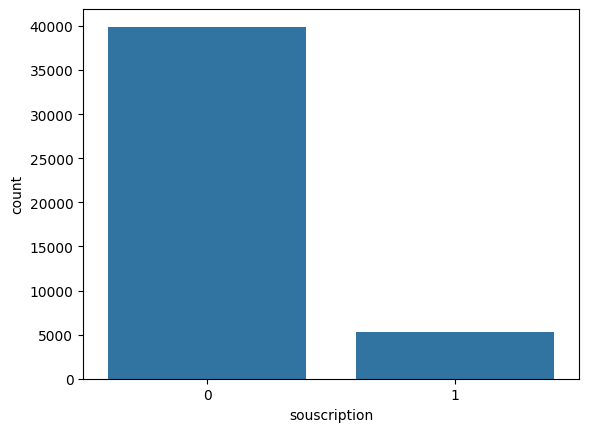

In [12]:
afficher_histogramme_etiquettes(encoded_data, "souscription")

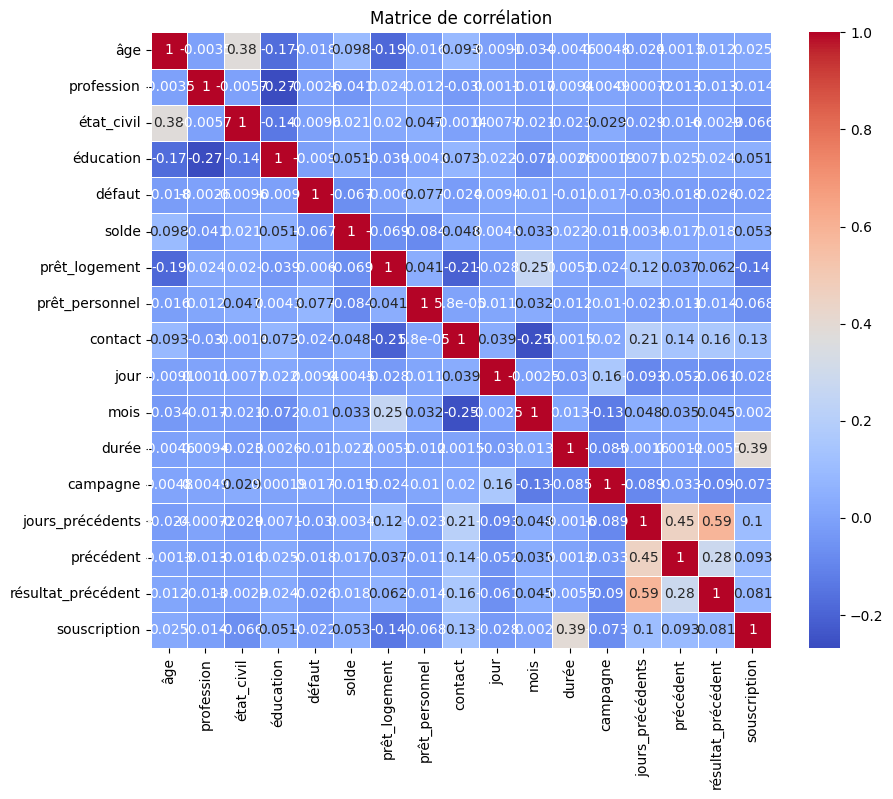

In [13]:
# Matrice de corrélation
correlation_matrix(encoded_data)

En regardant la variable d'intêret (la souscription) , on peut observer que c'est avec la durée de la dernière communication qu'elle est la plus corrélée (=0,39) <br> 
Ce qui semble cohérent puisque les clients ayant souscrits passent plus de temps avec le conseiller. 

**III - Comparaison de modèles de classification**

*1. Modèle KNN :*


Acccuracy (KNN): 88.61%
F1-score KNN : 61.48%
Recall score (KNN) : 58.77%
Précision (KNN) : 74.14%
Matrice de confusion (KNN):


<Axes: >

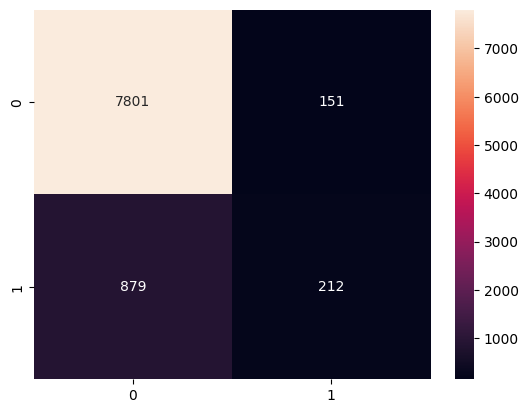

In [14]:
encoded_data_KNN,encoder=encode_categories(df)

X, y = split_data(encoded_data_KNN, "souscription")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=30)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_score_knn = f1_score(y_test, y_pred_knn, average='macro') 
confusion_knn = confusion_matrix(y_test, y_pred_knn)
recall_knn=recall_score(y_test, y_pred_knn, average='macro') 
precision_knn =precision_score(y_test, y_pred_knn, average='macro')  

print("\nAcccuracy (KNN): {:.2f}%".format(accuracy_knn * 100))
print("F1-score KNN : {:.2f}%".format(f1_score_knn * 100))
print("Recall score (KNN) : {:.2f}%".format(recall_knn * 100))
print("Précision (KNN) : {:.2f}%".format(precision_knn * 100))
print('Matrice de confusion (KNN):')

sns.heatmap(confusion_knn, fmt='d', annot=True)

Avec la matrice de confusion du modèle KNN, on peut voir qu'on a manqué 879 clients à cibler qui étaient potentiellement intéressés. <br>
151 clients ont été ciblés alors qu'ils n'étaient pas intéressés.

In [15]:
recall_c1 = recall_score(y_test, y_pred_knn, pos_label=1) # calcule du recall pour la classe 1 
print(f"Recall (Classe 1) : {recall_c1*100:.2f}%")

Recall (Classe 1) : 19.43%


In [16]:
best_k, best_acc, best_f1 = meilleur_k(X, y, test_size=0.2, k_range=np.arange(1, 50))

print(f"Meilleure valeur de k : {best_k}")
print(f"Meilleure précision : {best_acc*100:.2f}%")
print(f"Meilleur F1-score : {best_f1*100:.2f}%")

Meilleure valeur de k : 33
Meilleure précision : 88.68%
Meilleur F1-score : 62.51%


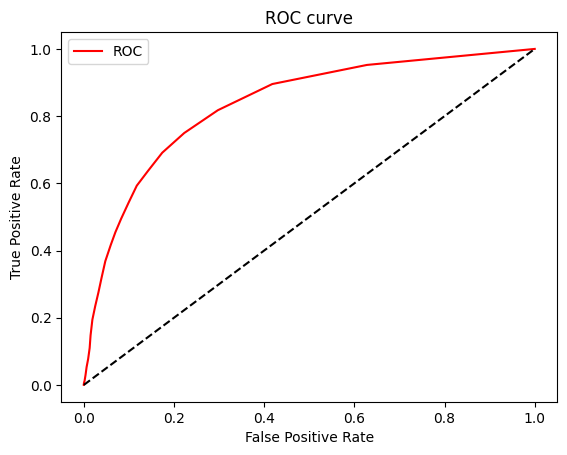

AUC (KNN) : 83.43 %


In [17]:
y_prob=knn.predict_proba(X_test)
y_prob=y_prob[:, 1]

fper, tper, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fper, tper)

auc_roc = roc_auc_score(y_true=y_test, y_score=y_prob)
print("AUC (KNN) : {:.2f} %".format(auc_roc*100))

*2. Modèle RandomForest :*

Accuracy (random forest) : 90.16 %
F1 score (random forest) : 72.46 %
Recall (random forest) : 69.14 %
Precision (random forest) : 78.32 %


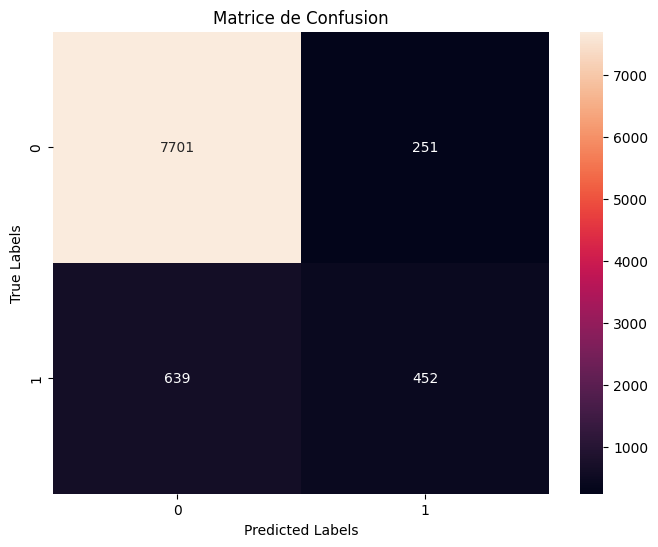

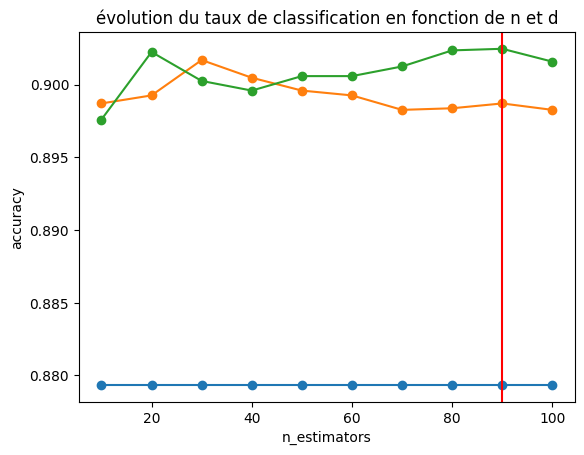

Meilleure ACC (RF) : 90.16 %
best_params : {'n_estimators': 90, 'max_depth': None}


In [18]:
encoded_data_RF,encoder=encode_categories(df)

X, y = split_data(encoded_data_RF, "souscription")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model=train_random_forest(X_train,y_train)

y_pred,acc_rf,f1_rf,recall_rf,prec_rf,cm_RF=evaluate_RF_model(rf_model, X_test, y_test)
print("Accuracy (random forest) : {:.2f} %".format(acc_rf*100))
print("F1 score (random forest) : {:.2f} %".format(f1_rf*100))
print("Recall (random forest) : {:.2f} %".format(recall_rf*100))
print("Precision (random forest) : {:.2f} %".format(prec_rf*100))
#affichage matrice de confusion
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_RF, annot=True, fmt="d")  
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")
plt.title("Matrice de Confusion")
plt.show()
n_estimators_list=np.arange(10,101,10)
max_depth_list=[1,10,None]
best_acc,best_params=improve_n_max_depth(X_train, y_train, X_test, y_test, n_estimators_list, max_depth_list)
print("Meilleure ACC (RF) : {:.2f} %".format(acc_rf*100))
print('best_params :',best_params)

Avec la matrice de confusion du modèle RF, on peut voir qu'on a manqué 639 clients à cibler qui étaient potentiellement intéressés. <br>
251 clients ont été ciblés alors qu'ils n'étaient pas intéressés.



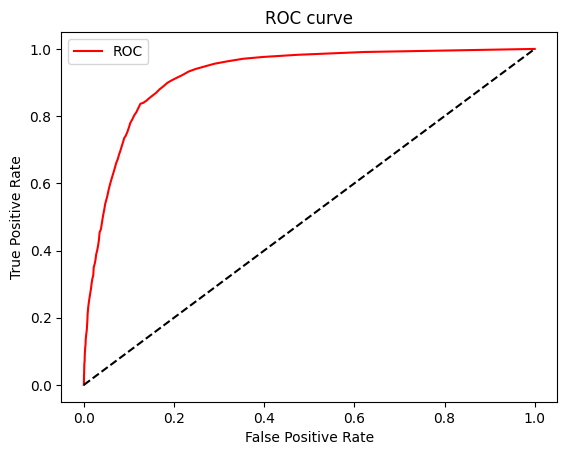

AUC (RandomForest) : 92.20 %


In [19]:
y_prob=rf_model.predict_proba(X_test)
y_prob=y_prob[:, 1]

fper, tper, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fper, tper)

auc_roc = roc_auc_score(y_true=y_test, y_score=y_prob)
print("AUC (RandomForest) : {:.2f} %".format(auc_roc*100))

*3. Modèle Arbre de décision :*

Exactitude : 87.58%
F1_score : 70.84%
Précision : 70.77%
Recall : 70.91%


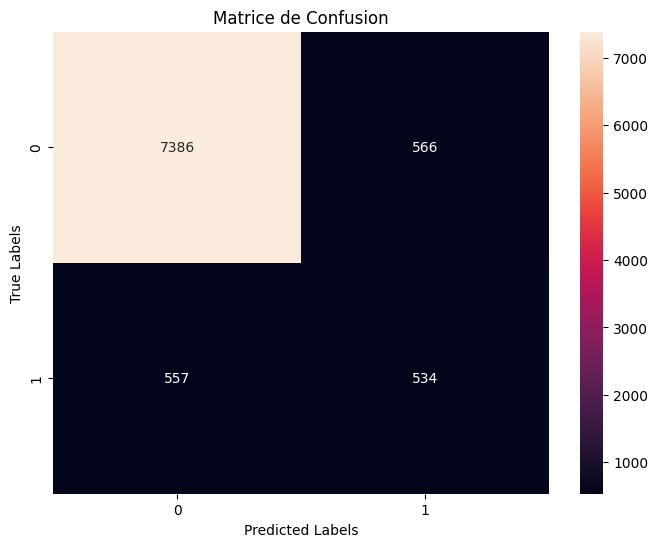

scores validation croisée : [0.87033453 0.87420514 0.87102571 0.87833541 0.87501728]
taux de classification moyen : 87.38 %
ecart type : 0.0029 %
best score : 89.44 %
best critere :  gini
best max depth : 12


In [20]:
encoded_data_A,encoder=encode_categories(df)

X, y = split_data(encoded_data_A, "souscription")

X_train,y_train,X_test,y_test, accuracy, f1 ,prec,recall, conf,CART = train_evaluate_cart( X, y, 0.2 )

#affichage métriques d'évaluation 
print("Exactitude : {:.2f}%".format((accuracy * 100)))
print("F1_score : {:.2f}%".format((f1* 100)))
print("Précision : {:.2f}%".format((prec* 100)))
print("Recall : {:.2f}%".format((recall* 100)))

#affichage matrice de confusion
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf, annot=True, fmt="d")  
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")
plt.title("Matrice de Confusion")
plt.show()
#affichage arbre de décision
#fig = plt.figure(figsize=(25,20))
#_= tree.plot_tree(CART, feature_names=encoded_data.columns,class_names= {0:'acc', 1:'good', 2 : 'unacc' , 3 : 'vgood'},filled=True) # pas d'affichage car illisible et pas pertinent 

#cross-validation
scores=cross_val_score(CART,X_train,y_train)
print("scores validation croisée :",scores)
print("taux de classification moyen : {:.2f} %".format(scores.mean()*100))
print("ecart type : {:.4f} %".format(scores.std()))

liste_criteres=["gini","entropy"]
list_max_depth=np.arange(3,16)
best_sc,best_c,best_d=plot_cart_evaluation(X_train,y_train,X_test,y_test,liste_criteres,list_max_depth)
print("best score : {:.2f} %".format(best_sc*100))
print("best critere : ",best_c)
print("best max depth :",best_d)

Avec la matrice de confusion du modèle CART, on peut voir qu'on a manqué 557 clients à cibler qui étaient potentiellement intéressés. <br>
566 clients ont été ciblés alors qu'ils n'étaient pas intéressés.


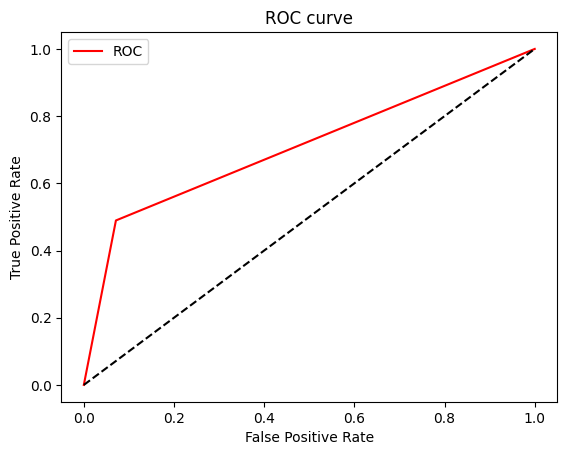

AUC (DecisionTree) : 70.91 %


In [21]:
y_prob=CART.predict_proba(X_test)
y_prob=y_prob[:, 1]

fper, tper, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fper, tper)

auc_roc = roc_auc_score(y_true=y_test, y_score=y_prob)
print("AUC (DecisionTree) : {:.2f} %".format(auc_roc*100))

*4. Modèle XGBoost :*

Accuracy (XGBoost) : 90.61%
F1-score (XGBoost) : 75.72%
Recall score (XGBoost) : 73.51%
Précision (XGBoost) : 78.68%
Matrice de confusion (XGBoost):


<Axes: >

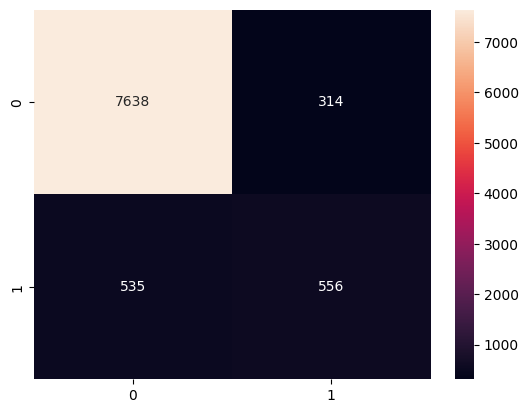

In [22]:
encoded_data_XG,encoder=encode_categories(df)
X, y = split_data(encoded_data_XG, "souscription")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle XGBOOST :
xgb_model = XGBClassifier(random_state=42)

# Entraînement
xgb_model.fit(X_train, y_train)

# Prédiction
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
accuracy_xgboost = accuracy_score(y_test, y_pred_xgb)
f1_score_xgboost = f1_score(y_test, y_pred_xgb, average='macro')
confusion_xgboost = confusion_matrix(y_test, y_pred_xgb)
recall_xgboost=recall_score(y_test, y_pred_xgb, average='macro')
precision_xgboost =precision_score(y_test, y_pred_xgb, average='macro')  


# Affichage des résultats : taux de classification et matrice de confusion
print("Accuracy (XGBoost) : {:.2f}%".format(accuracy_xgboost * 100))
print("F1-score (XGBoost) : {:.2f}%".format(f1_score_xgboost * 100))
print("Recall score (XGBoost) : {:.2f}%".format(recall_xgboost * 100))
print("Précision (XGBoost) : {:.2f}%".format(precision_xgboost * 100))
print('Matrice de confusion (XGBoost):')
sns.heatmap(confusion_xgboost, fmt='d', annot=True)

Avec la matrice de confusion du modèle XGBoost, on peut voir qu'on a manqué 535 clients à cibler qui étaient potentiellement intéressés. <br>
314 clients ont été ciblés alors qu'ils n'étaient pas intéressés.


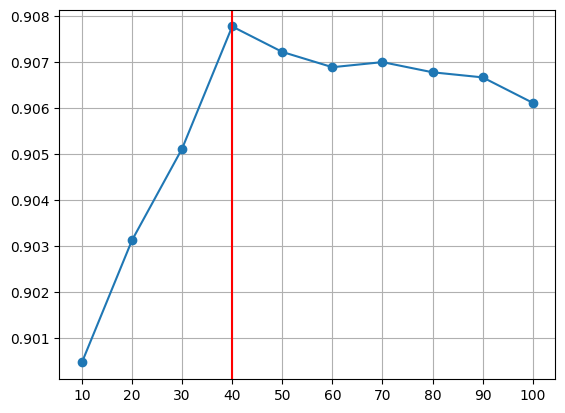

Best score : 90.78%
best n estimators :  40


In [23]:
best_sc,best_n=train_evaluate_xgboost(X_train,y_train,X_test,y_test,np.arange(10,101,10))
print("Best score : {:.2f}%".format(best_sc * 100))
print("best n estimators : ",best_n)

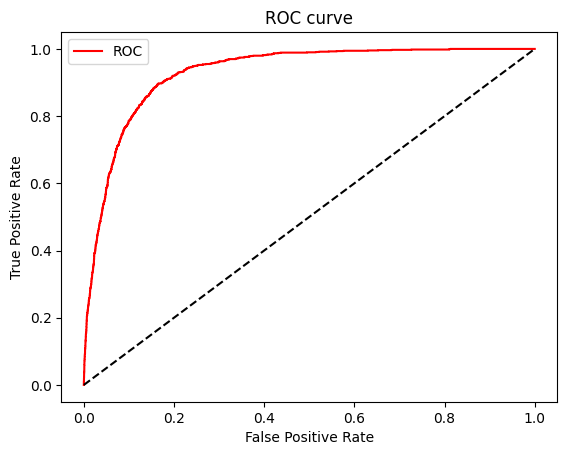

AUC (XGBoost) : 92.96 %


In [24]:
y_prob=xgb_model.predict_proba(X_test)
y_prob=y_prob[:, 1]

fper, tper, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fper, tper)

auc_roc = roc_auc_score(y_true=y_test, y_score=y_prob)
print("AUC (XGBoost) : {:.2f} %".format(auc_roc*100))

**IV - Apprentissage des modèles après ACP**

In [40]:
liste_classe_ACP = [1,3,5,7,9,11,13,15,16]
encoded_data_ACP,encoder=encode_categories(df)
X_acp, y_acp = split_data(encoded_data_ACP, "souscription")
knn_variable = 33
forest_variable = 90
XGBoost_variable = 40
Decision_variable = 12
knn_score = []
RandomForest_score = []
ArbreDecision_score = []
XGBoost_score = []

for classe in liste_classe_ACP:
    acp = PCA(n_components=classe)
    X_reduced = acp.fit_transform(X_acp)
    X_train_ACP, X_test_ACP, y_train_ACP, y_test_ACP = train_test_split(X_reduced, y_acp, test_size=0.2, random_state=42)
    
    #Modele KNN
    knn_ACP = KNeighborsClassifier(n_neighbors=knn_variable)
    knn_ACP.fit(X_train_ACP, y_train_ACP)
    y_pred_knn_ACP = knn_ACP.predict(X_test_ACP)
    accuracy_knn_ACP = accuracy_score(y_test_ACP, y_pred_knn_ACP)
    knn_score.append(accuracy_knn_ACP)

    #Modele RandomForest
    RandomForest_ACP=RandomForestClassifier(random_state=42,n_estimators=forest_variable)
    RandomForest_ACP.fit(X_train_ACP,y_train_ACP)
    y_pred_RandomForest_ACP = RandomForest_ACP.predict(X_test_ACP)
    accuracy_RandomForest_ACP = accuracy_score(y_test_ACP, y_pred_RandomForest_ACP)
    RandomForest_score.append(accuracy_RandomForest_ACP)

    #Modele DecisionTree
    DecisionTree_ACP = DecisionTreeClassifier(random_state=42, max_depth=Decision_variable) 
    DecisionTree_ACP.fit(X_train_ACP,y_train_ACP)
    y_pred_DecisionTree_ACP = DecisionTree_ACP.predict(X_test_ACP) 
    DecisionTree_score_ACP = accuracy_score(y_test_ACP, y_pred_DecisionTree_ACP)
    ArbreDecision_score.append(DecisionTree_score_ACP)

    #Modele XGBoost
    xgb_model_ACP = XGBClassifier(random_state=42, n_estimators=XGBoost_variable)
    xgb_model_ACP.fit(X_train_ACP,y_train_ACP)
    y_pred_xgb_ACP = xgb_model_ACP.predict(X_test_ACP)
    accuracy_xgboost_ACP = accuracy_score(y_test_ACP, y_pred_xgb_ACP)
    XGBoost_score.append(accuracy_xgboost_ACP)

print("KNN score : ")
arrondir(knn_score)

print("RandomForest score : ")
arrondir(RandomForest_score)

print("ArbreDecision score : ")
arrondir(ArbreDecision_score)

print("XGBoost score : ")
arrondir(XGBoost_score)


KNN score : 
[0.87913, 0.88555, 0.88654, 0.88665, 0.88665, 0.88665, 0.88676, 0.88676, 0.88676]
RandomForest score : 
[0.81743, 0.88566, 0.89251, 0.89528, 0.89605, 0.89716, 0.9007, 0.90059, 0.9007]
ArbreDecision score : 
[0.87471, 0.88134, 0.87946, 0.88676, 0.88488, 0.88632, 0.88798, 0.88643, 0.88544]
XGBoost score : 
[0.87935, 0.89296, 0.89329, 0.89672, 0.89959, 0.89893, 0.9039, 0.90147, 0.90158]
